# 5. XGBoost

Realicemos una predicción basada en Gradient Boosted Trees (GBT).

Se parte de los datos analizados, normalizados y acotados logrados en el punto 0, para el training.

Al igual que RandomForest, GBT clasifica mediante el uso de un conjunto de árboles de decisión. Sin embargo, en este caso, los árboles se construyen secuencialmente, añadiendo en cada iteración el árbol que mejor compense por los errores de los árboles ya existentes. Se le llama método de gradiente porque el modelo evoluciona en dirección al menor error, árbol a árbol. Para este caso, la herramienta más usada es XGBoost.

Partiendo de una contrucción del modelo, haremos un proceso iterativo de validación y ajuste del mismo (modificando parámetros y variables), hasta obtener el que mejor predice nuestra target, sin infra o sobreajustes

## Importación de datos y selección de variables


In [1]:
#Librerías a usar

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

#Importación de datos
data = pd.read_csv("data/PreciosCasas/train_final.csv", sep='\t', encoding='utf-8') 

# print a summary of the data in Melbourne data
data.describe()

,Unnamed: 0,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,...,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000
mean,728.805765,729.805765,56.877145,10460.434454,6.094715,5.576527,1971.194235,1984.818806,439.128346,46.645161,...,0.003432,0.082361,0.002059,0.868909,0.069321,0.002745,0.008236,0.013727,0.821551,0.084420
std,421.402158,421.402158,42.339638,9862.564977,1.376542,1.113638,30.190353,20.640669,432.964939,161.471529,...,0.058500,0.275008,0.045345,0.337616,0.254086,0.052342,0.090410,0.116395,0.383022,0.278112
min,0.000000,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,364.000000,365.000000,20.000000,7540.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,729.000000,730.000000,50.000000,9473.000000,6.000000,5.000000,1972.000000,1994.000000,383.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1093.000000,1094.000000,70.000000,11600.000000,7.000000,6.000000,2000.000000,2004.000000,712.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1459.000000,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,2188.000000,1474.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [2]:
data.shape

(1457, 222)

In [3]:
#Vamos a ver que variables elegimos: todas como columnas y el SalesPrice como target

X= data.ix[:, data.columns != 'Unnamed: 0']
X= X.ix[:, X.columns != 'SalePrice']
X= X.ix[:, X.columns != 'Id']

print (X.head())

y= data['SalePrice']

   MSSubClass  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0          60     8450            7            5       2003          2003   
1          20     9600            6            8       1976          1976   
2          60    11250            7            5       2001          2002   
3          70     9550            7            5       1915          1970   
4          60    14260            8            5       2000          2000   

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF          ...            \
0         706           0        150          856          ...             
1         978           0        284         1262          ...             
2         486           0        434          920          ...             
3         216           0        540          756          ...             
4         655           0        490         1145          ...             

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0 

/root/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/root/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/root/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-d

## Implementación del modelo XGBoost

Haremos primero un ajuste del modelo sin ajustar, lo analizaremos, y luego iremos probando con los distintos tipos de regularización a ver como lo vamos mejorando.



In [4]:
#Importación de librerías

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

#Separamos los datos en dos grupos, 
train_X, test_X, train_y, test_y = train_test_split( X, y,random_state = 0)


/root/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
# Modelo XGBRegressor 
from xgboost import XGBRegressor

my_model = XGBRegressor()  # Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [6]:
#Evaluación del error cometido
predictions = my_model.predict(test_X)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 0.0869101697169


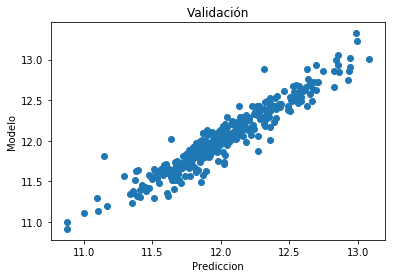

In [7]:
# Veamoslo en un scatter plot
plt.scatter(predictions,test_y);
plt.title('Validación');
plt.ylabel('Modelo');
plt.xlabel('Prediccion');
plt.show()


Vemos que el modelo en sí ya está bien, sin embargo, vamos a jugar con los diferentes parámetros del modelo, dado que estos pueden afectar mucho a la precisión y velocidad en el mismo

**n_estimators y early_stopping_rounds**

    - n_estimators sirve para indicar cuantas veces hacemos el ciclo descrito antes GBT, y evitar que se produzcan overfitting como underfitting. Normalmente los valores oscilan entre 100 - 1000

    - early_stopping_rounds es el sistema por el cual paro las iteraciones una vez han logrado una mejora significativa. Normalmente se usa el valor 5

Probemoslo

In [8]:
# Modelo XGBoost
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [9]:
#Evaluación del error cometido
predictions = my_model.predict(test_X)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 0.0835686751695


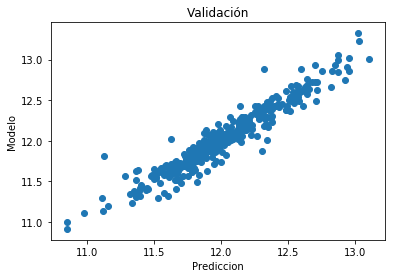

In [10]:
# Veamoslo en un scatter plot
plt.scatter(predictions,test_y);
plt.title('Validación');
plt.ylabel('Modelo');
plt.xlabel('Prediccion');
plt.show()


- **learning_rate**
    Esto es útil si queremos evitar el overfit. En vez ir cogiendo simlemente las redicciones de cada componente y sumarlas, vamos a multiplicarlas por un número, de forma que cada componente-arbol nuevo que ensamblemos, aporte menos
    Lo habitual es un bajo learning_rate para obtener modelos más ajustados

In [11]:
# Modelo XGBoost
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [12]:
#Evaluación del error cometido
predictions = my_model.predict(test_X)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 0.0856997079394


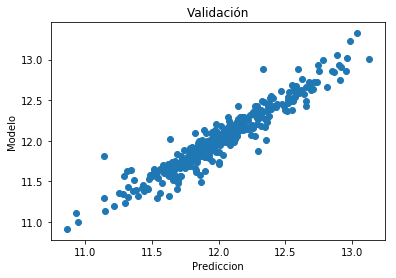

In [13]:
# Veamoslo en un scatter plot

plt.scatter(predictions,test_y);
plt.title('Validación');
plt.ylabel('Modelo');
plt.xlabel('Prediccion');
plt.show()

En efecto, vemos que el error cometido puede ser un poco más grande, pero es precisamente lo que estamos intentando lograr, que el modelo sea más universal


- **n_jobs**
    Esto sólo es como nota, por si el ordenador va muy lento 
    Lo habitual es un número igual al de cores de tu máquina